In [1]:
using WindTunnelFlow
using Plots
using Random
using LinearAlgebra

In [82]:
t_final = 7.0
t_open = 0.4
t_close = 4.4
V_cw_trend(t,t_open,t_close) = 0.24 * (t_open <= t < t_close ? (1 - exp(-(t-t_open)/0.41)) : 0.0) + (t_close <= t ? 0.24*(1 - exp(-(t_close-t_open)/0.41)) * exp(-(t-t_close)/0.11) : 0.0)

function create_samples(t_sample,t_open,t_close,μ,r)
    V_cw_sample = V_cw_trend.(t_sample,t_open,t_close) .+ randn(size(t_sample))*sqrt(r) .+ μ;
    return V_cw_sample
end

create_samples (generic function with 2 methods)

In [83]:
function kalman_predict(current_state_estimate, current_state_covariance, process_noise_covariance, F = 1)
    # State extrapolation
    next_state_predicted_estimate = F * current_state_estimate
    # Covariance extrapolation
    next_state_predicted_covariance = F * current_state_covariance * F' + process_noise_covariance
    
    return next_state_predicted_estimate, next_state_predicted_covariance
end

function kalman_update(current_state_predicted_estimate, current_state_predicted_covariance, current_measurement, measurement_noise_covariance, H)
    # Innovation
    innovation = current_measurement - H * current_state_predicted_estimate
    # Kalman gain
    K = current_state_predicted_covariance * H' * inv(H * current_state_predicted_covariance * H' + measurement_noise_covariance)
    # State update
    current_state_estimate = current_state_predicted_estimate + K * innovation
    # Covariance update
    current_state_covariance = (I - K * H) * current_state_predicted_covariance
    
    return current_state_estimate, current_state_covariance
end

kalman_update (generic function with 1 method)

In [4]:
function suction_velocity!(vel,pts,t,phys_params)
    V_out = phys_params["V_SD"]
    vel .= -V_out
end

function inflow_velocity!(vel,pts,t,phys_params)
    V_in = phys_params["V_in"]
    vel .= V_in
end

inflow_velocity! (generic function with 1 method)

In [5]:
# Wind tunnel characteristics

H_TS = 0.61 # m
W_TS = 0.61 # m
L_TS = 2.1 # m
u_0 = 2.2 # m/s (not sure what this value really represents in this transient case)
x_SD_lo_over_L_TS = 0.4
x_SD_hi_over_L_TS = 0.6

x_cw = L_TS/2
y_cw = H_TS/2

0.305

In [23]:
A_TS = H_TS * W_TS # m^2
Q_in = u_0 * A_TS # m^3/s
V_in = Q_in / A_TS

x_SD_lo = x_SD_lo_over_L_TS * L_TS
x_SD_hi = x_SD_hi_over_L_TS * L_TS
L_SD = x_SD_hi - x_SD_lo
A_SD = L_SD * W_TS

0.25619999999999993

In [24]:
params = Dict()
params["Re"] = 200
params["grid Re"] = 2.0
params["wind tunnel length"] = L_TS
params["wind tunnel height"] = H_TS
params["wind tunnel center"] = (L_TS / 2, H_TS / 2)
params["freestream speed"] = V_in
params["freestream angle"] = 0.0
params["V_in"] = V_in
t_final = 5.0
xlim = (-0.1 * L_TS, 1.1 * L_TS)
ylim = (-0.1 * H_TS, 1.1 * H_TS)
g = setup_grid(xlim, ylim, params)

PhysicalGrid{2}((270, 77), (30, 8), 0.01, ((-0.29, 2.39), (-0.07, 0.68)))

In [25]:
# Create the inflow

N = ceil(Int, H_TS / surface_point_spacing(g,params))
inflow_boundary = BasicBody(
    zeros(N),
    collect(range(0, H_TS, N)),
    closuretype=RigidBodyTools.OpenBody)
inflow = UniformFlowThrough(inflow_boundary,inflow_velocity!,3)

params["inlets"] = [inflow];

In [26]:
# Create the suction at the top of the wind tunnel

N = ceil(Int, L_SD / surface_point_spacing(g,params))
suction_boundary = BasicBody(
    collect(range(x_SD_lo, x_SD_hi, N)),
    H_TS * ones(N);
    closuretype=RigidBodyTools.OpenBody)
suction = UniformFlowThrough(suction_boundary,suction_velocity!,1)

params["outlets"] = [suction];

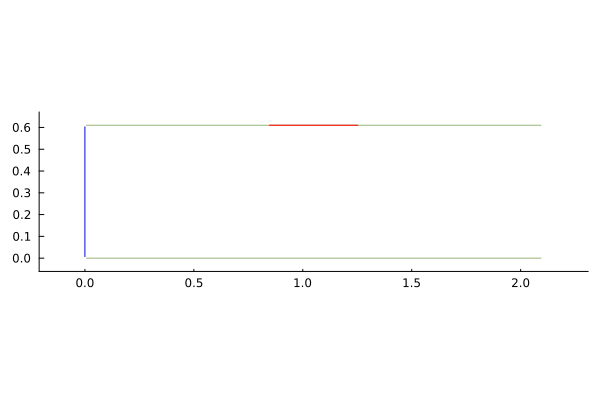

In [27]:
wt_walls = create_windtunnel_boundaries(g,params,withinlet=false)
plot(wt_walls,xlim=xlim,ylim=ylim)
plot!(suction.boundary,lc=:red)
plot!(inflow.boundary,lc=:blue)

In [28]:
prob = WindTunnelProblem(g,phys_params=params;timestep_func=ViscousFlow.DEFAULT_TIMESTEP_FUNC,
                                   bc=ViscousFlow.get_bc_func(nothing))
sys = construct_system(prob);

First get the observation matrix from a reference value for Q_SD

In [59]:
Q_SD = 1.0
V_SD = Q_SD / A_SD

3.903200624512101

In [60]:
params["V_SD"] = V_SD

3.903200624512101

In [61]:
u0 = init_sol(sys)
tspan = (0.0,t_final)
integrator = init(u0,tspan,sys);

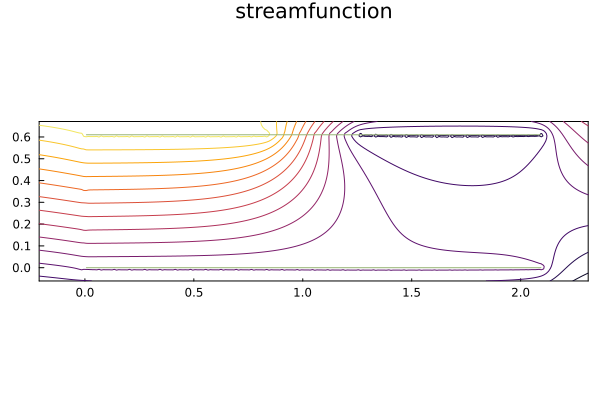

In [62]:
ψ = zeros_gridcurl(sys)
ViscousFlow.streamfunction!(ψ,integrator.sol.u[end].x[1],sys,0.0)
plot(ψ,g,title="streamfunction",xlims=xlim,ylims=ylim)
plot!(wt_walls)

In [63]:
wt_vel = zeros_grid(sys);
ViscousFlow.velocity!(wt_vel, zeros_gridcurl(sys), sys, 0.0);
vel_fcn = interpolatable_field(wt_vel,g);

In [64]:
H = vel_fcn[2](x_cw,y_cw)

1.157275162813809

In [182]:
q = 1e-7 # Process noise covariance
r = 1e-5 # Measurement noise covariance
μ = 0.0 # Measurement noise bias

Δt_sample = 0.01
t_sample = 0:Δt_sample:t_final

V_cw_sample = create_samples(t_sample,t_open,t_close,μ,r);

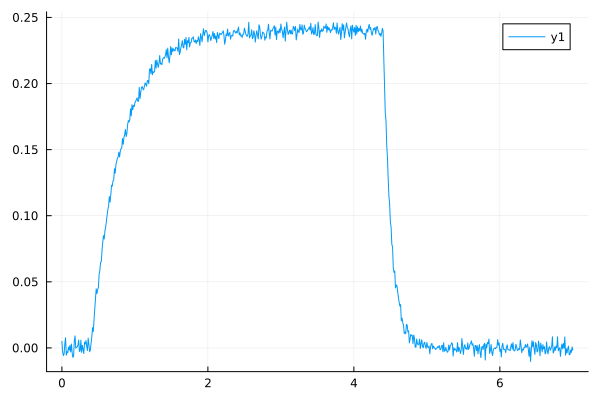

In [183]:
plot(t_sample,V_cw_sample)

Set initial estimates for the state and its covariance

In [192]:
# Initial prediction for state Q_SD
Q_SD_est_pred = 0.0;
ViscousFlow.velocity!(wt_vel, zeros_gridcurl(sys), sys, 0.0)
vel_fcn = interpolatable_field(wt_vel,g)
# Initial prediction for covariance
Q_SD_var_pred = 0.0001;

Now start the Kalman filter

In [193]:
Q_SD_est_hist = []
Q_SD_var_hist = []
V_cw_hist = []
t_hist = []

integrator = init(u0,tspan,sys);

t = 0
for i in 1:length(t_sample)
    
    t = t_sample[i]
    push!(t_hist,t)
    
    # Update step
    Q_SD_est, Q_SD_var = kalman_update(Q_SD_est_pred, Q_SD_var_pred, V_cw_sample[i], r, H)
    push!(Q_SD_est_hist,Q_SD_est)
    push!(Q_SD_var_hist,Q_SD_var)
    push!(V_cw_hist,H * Q_SD_est)
    
    # Prediction step
    Q_SD_est_pred, Q_SD_var_pred = kalman_predict(Q_SD_est, Q_SD_var, q)
    
end

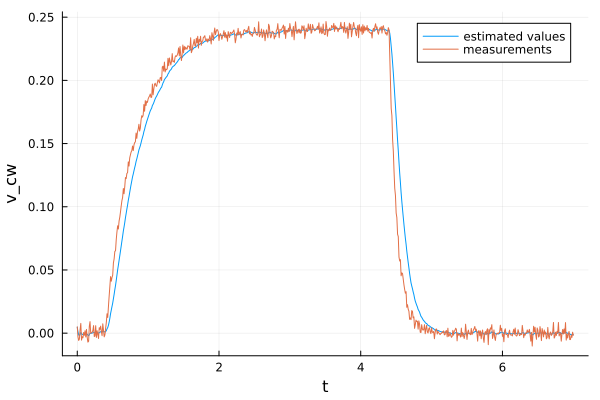

In [194]:
plot(t_hist,V_cw_hist,label="estimated values",xlabel="t",ylabel="v_cw")
plot!(t_sample,V_cw_sample,label="measurements")